**What is a brain tumor?**
- A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.



**Goal:** The significance of early detection cannot be overstated, as it plays a pivotal role in improving patient outcomes. By identifying brain tumors at an early stage, medical professionals can intervene promptly, leading to more effective treatment strategies. In the context of brain tumors, timely detection is vital for selecting the most appropriate and efficient treatment methods. The purpose of our project is to contribute to the early detection and classification of brain tumors using MRI (Magnetic Resonance Imaging).

**About Dataset**
- This dataset integrates three medical image datasets to enhance the comprehensive analysis and classification of brain tumors using advanced imaging techniques.
- This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: **glioma** - **meningioma** - **no tumor** and **pituitary**.





# **1. Import Libraries**






In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import pandas as pd
import cv2
import os
import io

# **2. Load Data**

**2-1. Connect To Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2-2. Unzip Dataset**

In [3]:
# from zipfile import ZipFile

# with ZipFile('drive/MyDrive/brain_dataset.zip', 'r') as zipOb:
#   zipOb.extractall('drive/MyDrive/brain_tumor_dataset')

**2-3. Loading and Resizing**

In [4]:
labels = []

X_train = []
y_train = []
X_test = []
y_test = []


trainPath = 'drive/MyDrive/brain_tumor_dataset'+'/Training/'
testPath = 'drive/MyDrive/brain_tumor_dataset'+'/Testing/'


for folder in os.listdir(trainPath):
    labels.append(folder)


for i in labels:
    labelPath = os.path.join(trainPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    labelPath = os.path.join(testPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_test.append(img)
        y_test.append(i)

**2-4. Converting Lists to NumPy Arrays**

In [5]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train=X_train/255.0
X_test=X_test/255.0

**2-5. Checking Shape of NumPy Arrays**

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 128, 128, 3) (5712,)
(1311, 128, 128, 3) (1311,)


**2-6. Visualizing Random Samples from the Dataset**

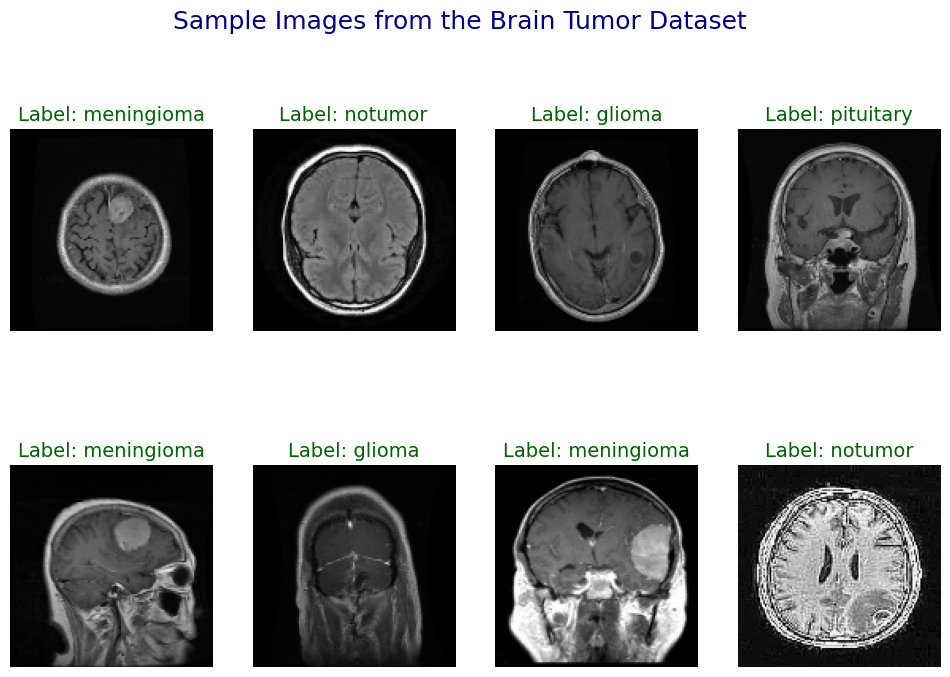

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Display sample images from the training set
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle('Sample Images from the Brain Tumor Dataset', fontsize=18, color='darkblue')

for i in range(2):
    for j in range(4):
        random_index = np.random.randint(0, len(X_train))
        ax = axes[i, j]
        ax.imshow(X_train[random_index], cmap='plasma')  # Use a colormap for better visualization
        ax.set_title(f'Label: {y_train[random_index]}', fontsize=14, color='darkgreen')
        ax.axis('off')
plt.show()


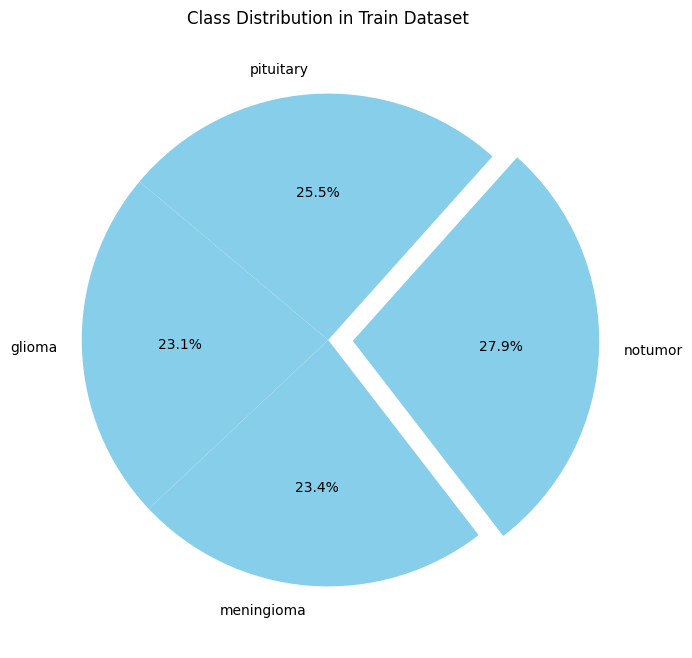

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_pie(labels, dataset_name):
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 8))
    colors = ['skyblue'] * len(unique_labels)  # Set all parts to the same color

    # Find the index of the largest slice
    explode = [0.1 if count == max(label_counts) else 0 for count in label_counts]

    # Set the border width for each wedge
    wedgeprops = {'linewidth': 2}

    plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, wedgeprops=wedgeprops)
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.show()

# Example usage
# Replace the placeholder below with your actual dataset and labels
plot_class_distribution_pie(y_train, "Train")


# **3. Data Preparation Pipeline: One-Hot Encoding, Splitting and Data Generation**

**3-1. One-Hot Encoding Labels**

In [9]:
# One Hot Encoding
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**3-2. Shuffling and Splitting Data**

In [10]:
# Let's shuffle the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**3-3. Checking Shapes of Training, Testing, and Validation Sets**

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 128, 128, 3) (4855, 4)
(1311, 128, 128, 3) (1311, 4)
(857, 128, 128, 3) (857, 4)




*   There are 4855 samples in the training set, each with an image shape of 128x128 pixels and 3 channels (RGB). The corresponding labels have a shape of (4855, 4), indicating a one-hot encoded format for the 4 classes.
*   The testing set contains 1311 samples with the same image shape as the training set. The labels have a shape of (1311, 4), suggesting one-hot encoding for the 4 classes.
*   The validation set has 857 samples with images of the same dimensions. The labels are in a one-hot encoded format with a shape of (857, 4).

# **4. Network Architecture**

**4-1. Convolutional Neural Network Architecture**

In [12]:
# Create a Sequential model
model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       147712    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 256)       0

# **5. Training**

**5-1. Early Stopping**

In [13]:
# from tensorflow.keras.callbacks import EarlyStopping
# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

**5-2. Training Convolutional Neural Network**

In [14]:
# history = model.fit(X_train, y_train, epochs =20, batch_size=32, validation_data=(X_val,y_val), callbacks=[early_stopping])
history = model.fit(X_train, y_train, epochs =30, batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
152/152 [==============================] - 22s 86ms/step - loss: 0.7692 - accuracy: 0.6746 - val_loss: 0.6061 - val_accuracy: 0.7340
Epoch 2/30
152/152 [==============================] - 9s 59ms/step - loss: 0.4590 - accuracy: 0.8249 - val_loss: 0.4142 - val_accuracy: 0.8448
Epoch 3/30
152/152 [==============================] - 9s 58ms/step - loss: 0.2855 - accuracy: 0.8904 - val_loss: 0.4344 - val_accuracy: 0.8273
Epoch 4/30
152/152 [==============================] - 9s 58ms/step - loss: 0.2077 - accuracy: 0.9217 - val_loss: 0.2711 - val_accuracy: 0.9008
Epoch 5/30
152/152 [==============================] - 9s 57ms/step - loss: 0.1490 - accuracy: 0.9429 - val_loss: 0.2887 - val_accuracy: 0.9032
Epoch 6/30
152/152 [==============================] - 9s 59ms/step - loss: 0.1098 - accuracy: 0.9590 - val_loss: 0.2889 - val_accuracy: 0.9265
Epoch 7/30
152/152 [==============================] - 9s 58ms/step - loss: 0.0619 - accuracy: 0.9763 - val_loss: 0.2760 - val_accuracy: 0.914

# **6. Model Predictions**

**6-1. Predictions and Ground Truth Label Processing**

In [15]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)

41/41 [==============================] - 2s 47ms/step


**6-2. Calculating Accuracy of CNN Model**

In [16]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print(accuracy)

0.9641495041952708


The model correctly predicted the class labels for approximately 96% of the samples in the test dataset.

# **7. Visualizing**

**7-1. Visualizing CNN Model Performance: Accuracy and Loss Over Epochs**

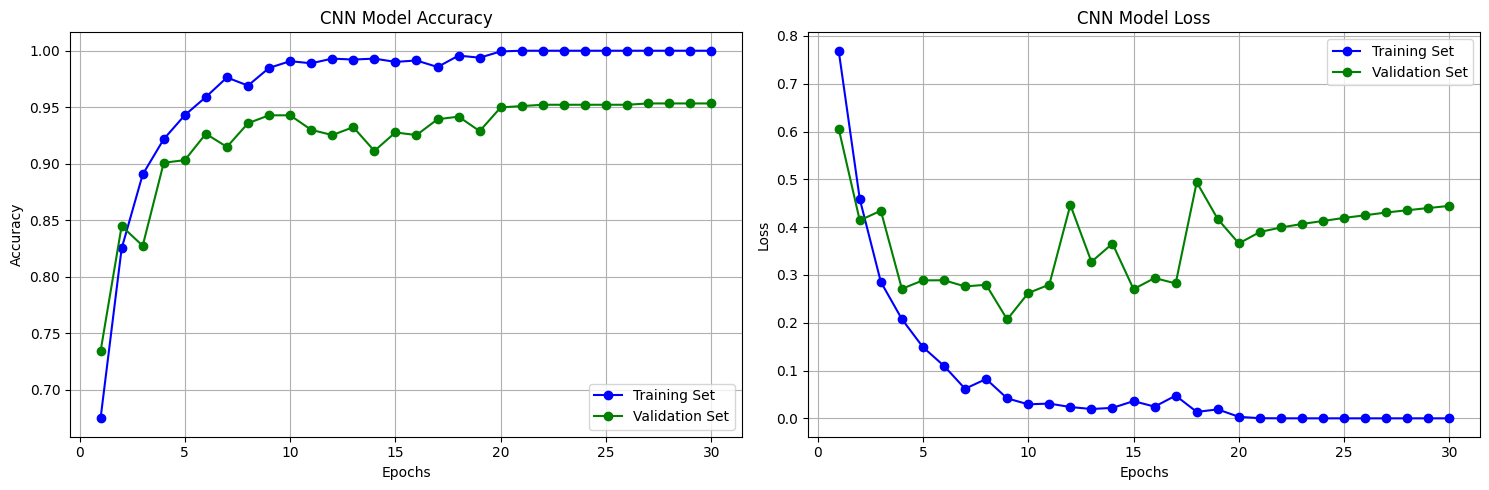

In [17]:
# Plot model performance with enhanced aesthetics
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_acc, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_loss, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

- The model is rapidly converged.
 - Augment training data by applying transformations like rotation, zooming, and flipping. This can introduce more variability and help the model generalize better.
- Adjusting the learning rate helps to reduce fluctuations.

**7-2. confusion Matrix**

41/41 [==============================] - 1s 19ms/step


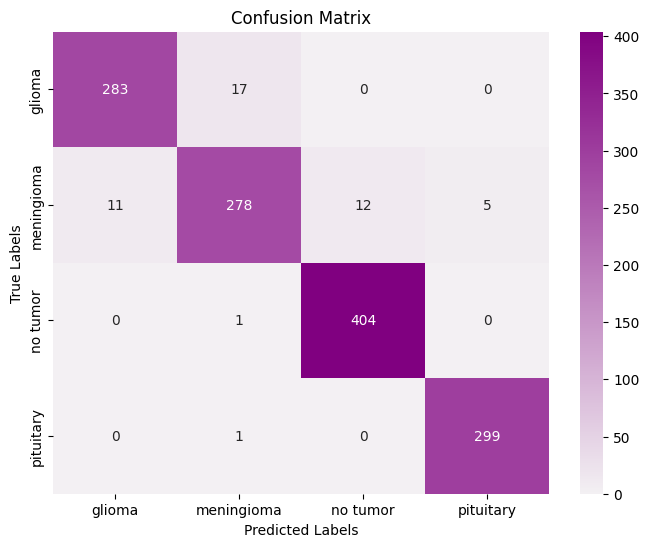

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and X_test, y_test are your test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a colormap
cmap = sns.light_palette("purple", as_cmap=True)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
